In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange                                         
from itertools import chain                                                     
from skimage.io import imread, imshow, concatenate_images                       
from skimage.transform import resize                                            
from skimage.morphology import label                                            
from sklearn.model_selection import train_test_split                           

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from PIL import Image, ImageEnhance

import tensorflow as tf

from keras.models import Model, load_model                                      
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout  
from keras.layers.core import Lambda, RepeatVector, Reshape                     
from keras.layers.convolutional import Conv2D, Conv2DTranspose                  
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D                  
from keras.layers.merge import concatenate, add                                 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau   
from keras.optimizers import Adam                                               
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 

In [ ]:
# TF & Keras versions 
import keras
print(tf.__version__)
print(keras.__version__)

In [ ]:
# Set model input dimensions
im_width = 496
im_height = 496

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#list of names of all images in the given path
ids = next(os.walk("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/images/"))[2]
print("No. of images = ", len(ids))

In [ ]:
X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

**CLASS PIXEL COUNTER**

In [ ]:
ids = next(os.walk("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/masks_shrubs/"))[2]  # I did this also for trees, rocks and shadows

y = np.zeros((len(ids), img.size[0], img.size[1], 1), dtype=np.float32)

for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)): 
    mas = load_img("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/masks_shrubs/"+id_) 
    red, green, blue = mas.split()
    mask = img_to_array(red)

    y[n] = mask/255.0    

In [ ]:
print('size of the y array: ', 800*800*13) 
print('no. of class pxs (1): ', np.count_nonzero(y == 1))
print('class representation: ', round(np.count_nonzero(y == 1)/(800*800*13)*100, 2), '%')
print('no. of non-class pxs (0): ', np.count_nonzero(y == 1))
print('non-class representation: ', round(np.count_nonzero(y == 0)/(800*800*13)*100, 2), '%')

**THE END OF CLASS PIXEL COUNTER**

**SHRUB PIXEL COUNTER PER IMAGE**

In [ ]:
#shrub pixel count per image
ids = next(os.walk("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/masks_shrubs/"))[2]  #2
print("No. of images = ", len(ids))
img = load_img("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/masks_shrubs/"+ids[1])
im_pxs = img.size[0] * img.size[0]

In [ ]:
im = np.zeros((img.size[0], img.size[0]), dtype=np.float32)
vys = np.zeros(len(ids))
percent = 1
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):  
  mas = load_img("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/masks_shrubs/"+id_) 
  red, green, blue = mas.split()
  mask = img_to_array(red)
  im = mask/255.0  
  vys[n] = (np.count_nonzero(im))*100/im_pxs    
  if vys[n] < percent:
    print(id_)

In [ ]:
plt.hist(vys, bins = [0,10,20,30,40,50,60,70,80,90,100], histtype='barstacked', color='blue') 
plt.title("Distribution of images based on the % of shrubs pixels") 
#plt.grid(which='minor', axis='both')
plt.grid(True)
plt.xlabel('% of shrub pixels in an image')
plt.ylabel('Number of images in the dataset')
plt.show()

**THE END OF SHRUB PIXEL COUNTER PER IMAGE**

**DATASET BALANCING - deleting images with below a certain % of the shrubs**

In [ ]:
ids = next(os.walk("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/masks_shrubs/"))[2]  
print("No. of images = ", len(ids))
img = load_img("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/masks_shrubs/"+ids[1])
im_pxs = img.size[0] * img.size[0]
print("No. of pxs = ",im_pxs)

In [ ]:
im = np.zeros((img.size[0], img.size[0]), dtype=np.float32)
lst = []
percent = 1
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):  
  mas = load_img("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/masks_shrubs/"+id_) 
  red, green, blue = mas.split()
  mask = img_to_array(red)
  im = mask/255.0  
  if ((np.count_nonzero(im))*100/im_pxs)<percent:
    lst.append(id_) 
    os.remove("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/masks_shrubs/"+id_)
    os.remove("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/images/"+id_) 

In [ ]:
print('% of images in the dataset that contain less than ', percent, '% of shrubs: ', len(lst)*100/len(ids))

**THE END OF DATASET BALANCING**

**DATA AUGMENTATION**

In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor # ref: Marcus D Bloice, Peter M Roth, Andreas Holzinger, Biomedical image augmentation using Augmentor, Bioinformatics, https://doi.org/10.1093/bioinformatics/btz259
import re

In [ ]:
# https://augmentor.readthedocs.io/en/master/code.html
p = Augmentor.Pipeline("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/images/")
# Point to a directory containing ground truth data. Images with the same file names will be added as ground truth data and augmented in parallel to the original data.
p.ground_truth("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/masks_shrubs/")
# Add operations to the pipeline:
p.rotate(probability=0.5, max_left_rotation=15, max_right_rotation=15) 
p.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=5) 
p.random_brightness(probability=0.4, min_factor=0.8, max_factor=1.2) 
p.flip_left_right(probability=0.9) # mirrors img through y axis
p.flip_top_bottom(probability=0.9) # mirrors img through x axis
p.skew(probability=0.7, magnitude=0.5) 
p.shear(probability=0.4, max_shear_left=10, max_shear_right=8) 

# generate a specific no. of augmented images
# masks and images are saved into the same folder!
p.sample(158) 

# OR process each image in the pipeline exactly once 
# p.process() 

In [ ]:
p.status()

In [ ]:
# get IDs of augmented images from the automatically generated folder 'output' 
ids = next(os.walk("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/images/output/"))[2]  
print("No. of images = ", len(ids))

In [ ]:
import shutil  
# IDs have to be loaded from the previous cell to run this one  
# removing the augmented images and masks from the 'output' folder into their corresponding folders

for i in range(len(ids)):
  match = re.search('images_original_', ids[i]) 
  matchh = re.search('_groundtruth_', ids[i])
  if match: #originals
    source = "/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/images/output/"+ids[i]
    destination = "/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/images/"+(ids[i].split('images_original_')[1]) 
    new_path = shutil.move(source, destination)
  elif matchh: #masks
    source = "/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/images/output/"+ids[i]
    destination = "/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/masks_shrubs/"+(ids[i].split('_groundtruth_(1)_images_')[1]) 
    new_path = shutil.move(source, destination)

**THE END OF DATA AUGMENTATION**

**FOR BIG DATASETS THAT DON'T FIT IN A MEMORY**

In [ ]:
from sklearn.utils import shuffle
ids_shuffled = shuffle(ids)

In [ ]:
images = np.array(ids)
labels = np.array(ids)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.1, random_state=1)

In [ ]:
# *based on: https://medium.com/@mrgarg.rajat/training-on-large-datasets-that-dont-fit-in-memory-in-keras-60a974785d71
import keras 
class My_Custom_Generator(keras.utils.Sequence) :
  
  def __init__(self, images, labels, batch_size) :
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    return np.array([
            resize((img_to_array(load_img("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/images/"+str(file_name)))), (496,496), mode = 'constant', preserve_range = True, anti_aliasing=True)
               for file_name in batch_x])/255.0, np.array([resize((img_to_array((load_img("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/masks_shrubs/"+str(file_name))).split()[0])), (496,496), mode = 'constant', preserve_range = True, anti_aliasing=True)
               for file_name in batch_y])/255.0   

In [ ]:
batch_size = 8 # normally 32, but for the biggest (500 x 500) px patches and model input (496 x 496) px had to be smaller

my_training_batch_generator = My_Custom_Generator(X_train, y_train, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_val, y_val, batch_size)

**THE END OF THE SECTION FOR BIG DATASETS THAT DON'T FIT IN A MEMORY**

#### Load the images and masks into arrays

In [ ]:
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)): 
    # loading images
    img = img_to_array(load_img("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/images/"+id_))
    x_img = resize(img, (496,496), mode = 'constant', preserve_range = True, anti_aliasing=True) 
   
    # loading masks
    mas = load_img("/content/drive/My Drive/Colab Notebooks/UNET-TGS/train/masks_shrubs/"+id_)
    # the binary masks contain 3 channels with identical values per channel
    red, green, blue = mas.split()
    maska = img_to_array(red)
    mask = resize(maska, (496,496), mode = 'constant', preserve_range = True, anti_aliasing=True) 
    
    # saving & normalizing images
    X[n] = x_img/255.0 
    y[n] = mask/255.0                                                  

In [ ]:
# split the data into training and validation 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# visualizing a random image along with its mask                       
ix = random.randint(0, len(X_train))  

has_mask = y_train[ix].max() > 0 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10)) 

ax1.imshow(X_train[ix, ..., :3], interpolation = 'bilinear') 
if has_mask:
    ax1.contour(y_train[ix].squeeze(), colors = 'black', linewidths = 3, levels = [0.5]) 
ax1.set_title('Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear') 
ax2.set_title('Mask')

In [ ]:
# adding a block of 2 convolutional layers and ReLU 
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
# definig the U-Net model
def get_unet(input_img, n_filters = 16, dropout = 0.05, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm) #from 128x128x1 to 8x8x256
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5) 
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)             #from 8x8x256 to 128x128x1
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)                       
    model = Model(inputs=[input_img], outputs=[outputs])
   
    return model

In [ ]:
input_img = Input((im_height, im_width, 3), name='img') 
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True) 
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), \
                                                                     tf.keras.metrics.TruePositives(), tf.keras.metrics.FalsePositives(), \
                                                                     tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TrueNegatives()])

In [ ]:
model.summary()

In [ ]:
# callbacks for saving the model while training, lower the learning rate if the validation loss plateaus and perform early stopping
callbacks = [
    EarlyStopping(patience=10, verbose=1),           
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1), 
    ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/UNET-TGS/Model_shrubs_500x500_AUG1658_496x496.h5',verbose=1, save_best_only=True, save_weights_only=True)]

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks, validation_data=(X_valid, y_valid))

# OR FOR BIG DATASETS THAT DON'T FIT IN A MEMORY ↓

#results = model.fit(my_training_batch_generator, epochs=50, callbacks=callbacks, validation_data = my_validation_batch_generator)

In [ ]:
estimator = model.fit(X_train, y_train,validation_data=(X_valid, y_valid))

In [ ]:
model.evaluate(X_train, y_train, verbose=1)

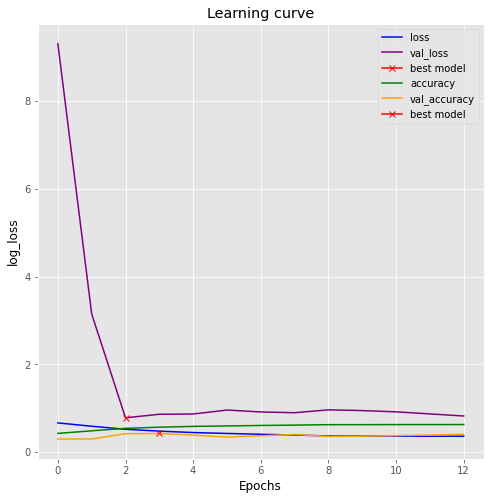

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss", color="blue")
plt.plot(results.history["val_loss"], label="val_loss",color="purple")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.plot(results.history["accuracy"], label="accuracy", color="green")
plt.plot(results.history["val_accuracy"], label="val_accuracy", color="orange")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs", color='black')
plt.ylabel("log_loss", color='black')
plt.legend()

### Inference

In [ ]:
# load the best model
model.load_weights('/content/drive/My Drive/Colab Notebooks/UNET-TGS/Model_shrubs_500x500_AUG1658_496x496.h5')

In [ ]:
model.evaluate(X_train, y_train, verbose=1)

47/47 [==============================] - 158s 3s/step - loss: 0.1225 - accuracy: 0.6982 - precision: 0.9990 - recall: 0.8715 - true_positives: 18419556.0000 - false_positives: 18206.0000 - false_negatives: 2716659.0000 - true_negatives: 9887373.0000 - auc: 0.9927 - precision_at_recall: 0.9999 - mean_io_u: 0.3100


[0.12253981083631516,
 0.6981947422027588,
 0.9990125894546509,
 0.8714689612388611,
 18419556.0,
 18206.0,
 2716659.0,
 9887373.0,
 0.9927310943603516,
 0.9999474883079529,
 0.30997878313064575]

In [ ]:
# Evaluate on validation set
model.evaluate(X_valid, y_valid, verbose=1)

# OR FOR BIG DATASETS THAT DON'T FIT INTO THE MEMORY ↓

#model.evaluate(my_validation_batch_generator, verbose=1)

6/6 [==============================] - 17s 3s/step - loss: 0.1308 - accuracy: 0.6872 - precision: 0.9978 - recall: 0.8734 - true_positives: 2072866.0000 - false_positives: 4542.0000 - false_negatives: 300329.0000 - true_negatives: 1085175.0000 - auc: 0.9918 - precision_at_recall: 0.9998 - mean_io_u: 0.3128


[0.130813866853714,
 0.6872121095657349,
 0.9978136420249939,
 0.8734495043754578,
 2072866.0,
 4542.0,
 300329.0,
 1085175.0,
 0.9917887449264526,
 0.9998202323913574,
 0.31283554434776306]

In [ ]:
# get F1 score, IoU and confusion matrix
def get_f1():
  f1 = 2*(model.evaluate(X_valid, y_valid, verbose=1)[3]*model.evaluate(X_valid, y_valid, verbose=1)[2])/(model.evaluate(X_valid, y_valid, verbose=1)[3]+model.evaluate(X_valid, y_valid, verbose=1)[2])
  return f1

def get_IoU():
  IoU = (model.evaluate(X_valid, y_valid, verbose=1)[4])/(model.evaluate(X_valid, y_valid, verbose=1)[4]+model.evaluate(X_valid, y_valid, verbose=1)[5]+model.evaluate(X_valid, y_valid, verbose=1)[6])
  return IoU

def get_confusion_matrix():
  header1 = ["Actual Positives", "Actual Negatives"]
  header2 = ["Predicted Positives", "Predicted Negatives"]
  data = np.array([[model.evaluate(X_valid, y_valid, verbose=1)[4], model.evaluate(X_valid, y_valid, verbose=1)[5]],
                 [model.evaluate(X_valid, y_valid, verbose=1)[6], model.evaluate(X_valid, y_valid, verbose=1)[7]]])
  row_format ="{:>20}" * (len(header1) + 1)
  print(row_format.format("", *header1))
  for header, row in zip(header2, data):
    print(row_format.format(header, *row))

# OR FOR BIG DATASETS THAT DON'T FIT INTO THE MEMORY ↓
'''
def get_f1(): 
  f1 = 2*(model.evaluate(my_validation_batch_generator, verbose=1)[3]*model.evaluate(my_validation_batch_generator, verbose=1)[2])/(model.evaluate(my_validation_batch_generator, verbose=1)[3]+model.evaluate(my_validation_batch_generator, verbose=1)[2])
  return f1

def get_IoU():
  IoU = (model.evaluate(my_validation_batch_generator, verbose=1)[4])/(model.evaluate(my_validation_batch_generator, verbose=1)[4]+model.evaluate(my_validation_batch_generator, verbose=1)[5]+model.evaluate(my_validation_batch_generator, verbose=1)[6])
  return IoU

def get_confusion_matrix():
  header1 = ["Actual Positives", "Actual Negatives"]
  header2 = ["Predicted Positives", "Predicted Negatives"]
  data = np.array([[model.evaluate(my_validation_batch_generator, verbose=1)[4], model.evaluate(my_validation_batch_generator, verbose=1)[5]],
                 [model.evaluate(my_validation_batch_generator, verbose=1)[6], model.evaluate(my_validation_batch_generator, verbose=1)[7]]])
  row_format ="{:>20}" * (len(header1) + 1)
  print(row_format.format("", *header1))
  for header, row in zip(header2, data):
    print(row_format.format(header, *row))
'''

In [ ]:
get_confusion_matrix()

6/6 [==============================] - 17s 3s/step - loss: 0.7019 - accuracy: 0.6853 - precision: 0.4955 - recall: 0.7818 - true_positives: 701177.0000 - false_positives: 713790.0000 - false_negatives: 195650.0000 - true_negatives: 1852295.0000 - auc: 0.8350 - precision_at_recall: 0.6664 - mean_io_u: 0.4154
                        Actual Positives    Actual Negatives
 Predicted Positives            701177.0            713790.0
 Predicted Negatives            195650.0           1852295.0


In [ ]:
get_f1()

6/6 [==============================] - 17s 3s/step - loss: 0.7019 - accuracy: 0.6853 - precision: 0.4955 - recall: 0.7818 - true_positives: 701177.0000 - false_positives: 713790.0000 - false_negatives: 195650.0000 - true_negatives: 1852295.0000 - auc: 0.8350 - precision_at_recall: 0.6664 - mean_io_u: 0.4154


0.606608548556809

In [ ]:
get_IoU()

6/6 [==============================] - 18s 3s/step - loss: 0.7019 - accuracy: 0.6853 - precision: 0.4955 - recall: 0.7818 - true_positives: 701177.0000 - false_positives: 713790.0000 - false_negatives: 195650.0000 - true_negatives: 1852295.0000 - auc: 0.8350 - precision_at_recall: 0.6664 - mean_io_u: 0.4154


0.4353468267129926

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)  
preds_val = model.predict(X_valid, verbose=1) 

6/6 [==============================] - 5s 753ms/step


In [ ]:
# predictions with a threshold 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
# plotting the results
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix].squeeze())                                      
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Prediction')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='red', levels=[0.5])
    ax[3].set_title('Binary Prediction');

### Predictions on training set

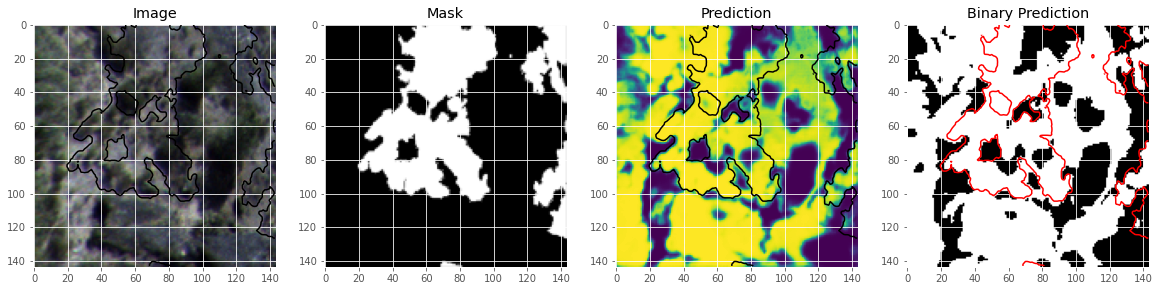

In [ ]:
# plot a concrete patch
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=5)

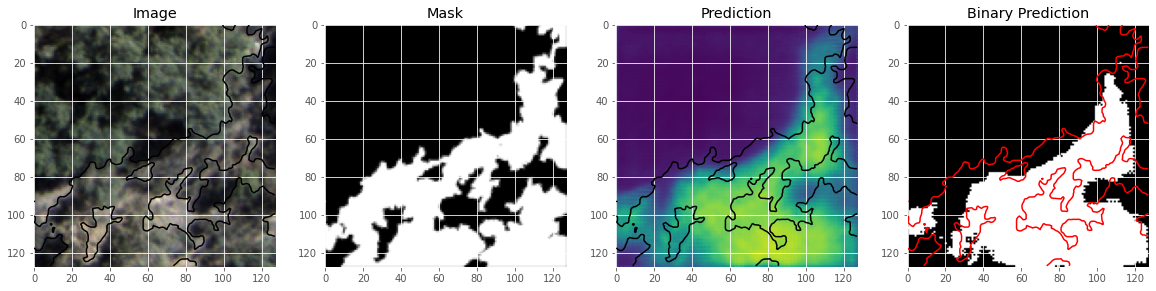

In [ ]:
# plot any patch
plot_sample(X_train, y_train, preds_train, preds_train_t)

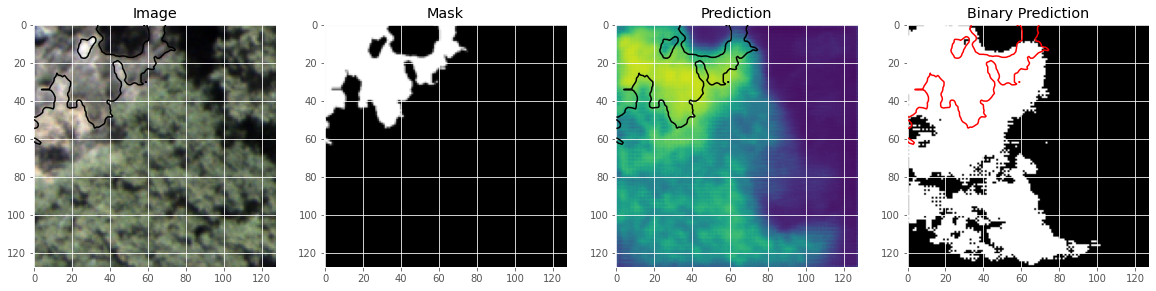

In [ ]:
# plot any patch
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on val set

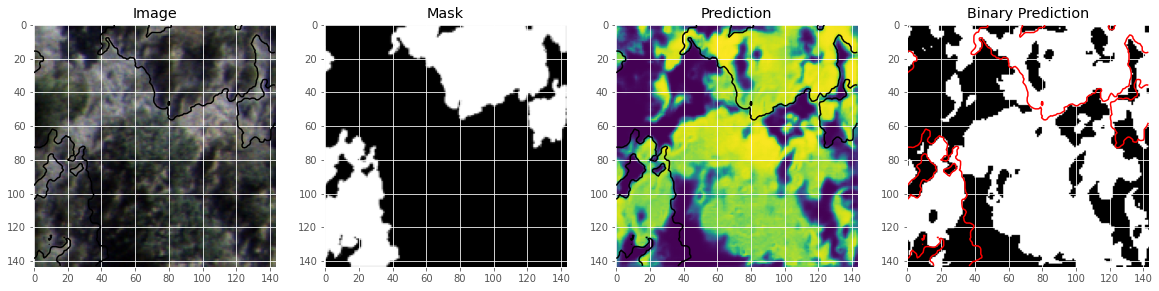

In [ ]:
# plot a concrete patch
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=10)

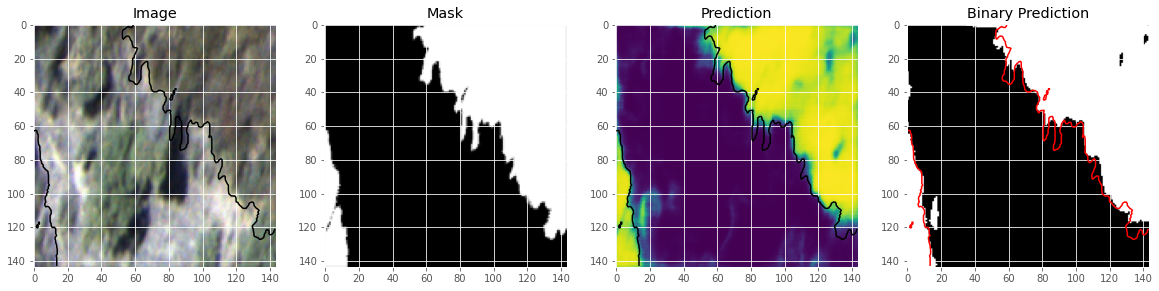

In [ ]:
# plot any patch
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

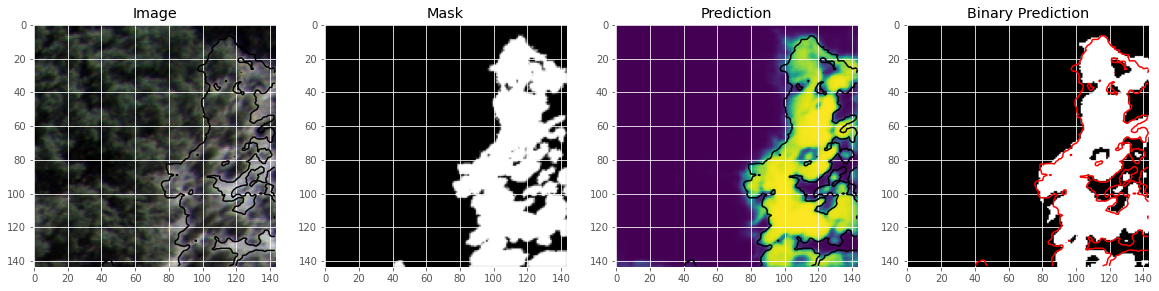

In [ ]:
# plot any patch
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

### Predictions on test set

In [ ]:
# automating the process of loading test data from different folders
folder = 'testO1'

In [ ]:
ids = next(os.walk("/content/drive/My Drive/Colab Notebooks/UNET-TGS/"+folder+"/images/"))[2]  #2
print("No. of images = ", len(ids))

No. of images =  128


In [ ]:
X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [ ]:
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)): 
    im = load_img("/content/drive/My Drive/Colab Notebooks/UNET-TGS/"+folder+"/images/"+id_)
    img = img_to_array(im)                                                                
    x_img = resize(img, (im_width, im_height), mode = 'constant', preserve_range = True)             
   
    mas = load_img("/content/drive/My Drive/Colab Notebooks/UNET-TGS/"+folder+"/masks_shrubs/"+id_) #2
    red, green, blue = mas.split()
    maska = img_to_array(red)
    mask = resize(maska, (im_width, im_height), mode = 'constant', preserve_range = True) 
   
    X[n] = x_img/255.0 
    y[n] = mask/255.0         

In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/UNET-TGS/Model_shrubs_500x500_AUG1658_496x496.h5')

In [ ]:
model.evaluate(X, y, verbose=1)

4/4 [==============================] - 11s 3s/step - loss: 0.5453 - accuracy: 0.7135 - precision_1: 0.8343 - recall_1: 0.5390 - true_positives_1: 523220.0000 - false_positives_1: 103888.0000 - false_negatives_1: 447449.0000 - true_negatives_1: 1022595.0000 - auc_1: 0.8473 - precision_at_recall_1: 0.8719 - mean_io_u_1: 0.2990


[0.5452746152877808,
 0.7135038375854492,
 0.8343379497528076,
 0.5390303134918213,
 523220.0,
 103888.0,
 447449.0,
 1022595.0,
 0.847303032875061,
 0.8719434142112732,
 0.29896998405456543]

In [ ]:
def get_f1():
  f1 = 2*(model.evaluate(X, y, verbose=1)[2]*model.evaluate(X, y, verbose=1)[3])/(model.evaluate(X, y, verbose=1)[2]+model.evaluate(X, y, verbose=1)[3])
  return f1

def get_IoU():
  IoU = (model.evaluate(X, y, verbose=1)[4])/(model.evaluate(X, y, verbose=1)[4]+model.evaluate(X, y, verbose=1)[5]+model.evaluate(X, y, verbose=1)[6])
  return IoU

def get_confusion_matrix():
  header1 = ["Actual Positives", "Actual Negatives"]
  header2 = ["Predicted Positives", "Predicted Negatives"]
  data = np.array([[model.evaluate(X_valid, y_valid, verbose=1)[2], model.evaluate(X_valid, y_valid, verbose=1)[4]],
                 [model.evaluate(X_valid, y_valid, verbose=1)[5], model.evaluate(X_valid, y_valid, verbose=1)[3]]])
  row_format ="{:>20}" * (len(header1) + 1)
  print(row_format.format("", *header1))
  for header, row in zip(header2, data):
    print(row_format.format(header, *row))

In [ ]:
get_f1()

4/4 [==============================] - 11s 3s/step - loss: 0.5453 - accuracy: 0.7135 - precision_1: 0.8343 - recall_1: 0.5390 - true_positives_1: 523220.0000 - false_positives_1: 103888.0000 - false_negatives_1: 447449.0000 - true_negatives_1: 1022595.0000 - auc_1: 0.8473 - precision_at_recall_1: 0.8719 - mean_io_u_1: 0.2990


0.6549349634028514

In [ ]:
get_IoU()

4/4 [==============================] - 11s 3s/step - loss: 0.5453 - accuracy: 0.7135 - precision_1: 0.8343 - recall_1: 0.5390 - true_positives_1: 523220.0000 - false_positives_1: 103888.0000 - false_negatives_1: 447449.0000 - true_negatives_1: 1022595.0000 - auc_1: 0.8473 - precision_at_recall_1: 0.8719 - mean_io_u_1: 0.2990


0.48691693414123216

In [ ]:
preds = model.predict(X, verbose=1)

1/1 [==============================] - 0s 2ms/step


In [ ]:
preds_t = (preds > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix].squeeze())                                      
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Prediction')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='red', levels=[0.5])
    ax[3].set_title('Binary Prediction');

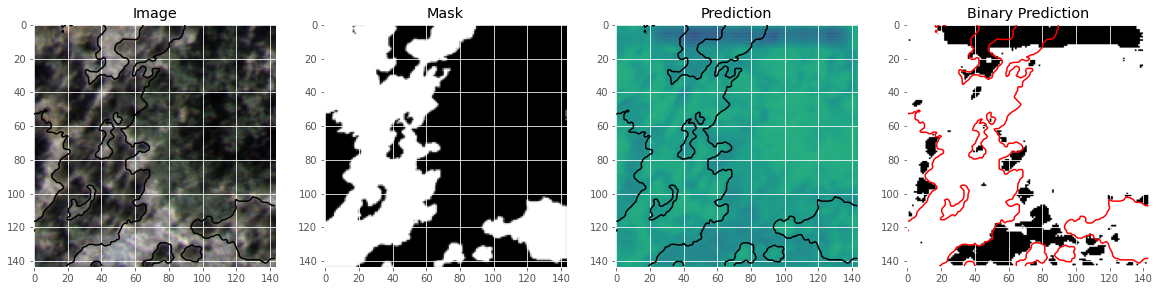

In [ ]:
plot_sample(X, y, preds, preds_t, ix=5)

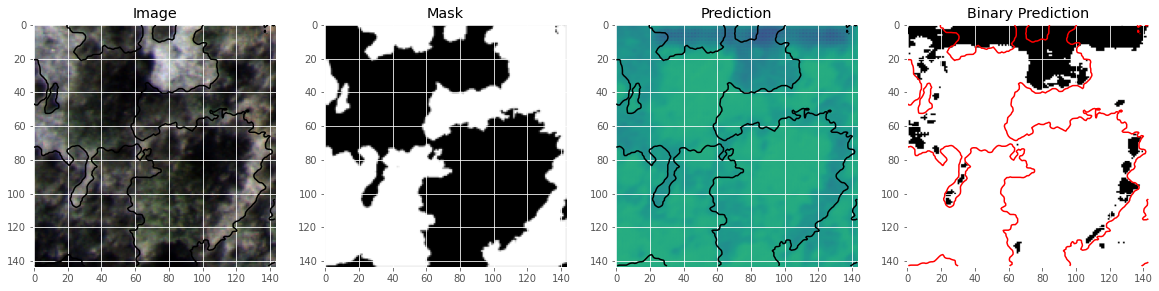

In [ ]:
plot_sample(X, y, preds, preds_t)